<a href="https://colab.research.google.com/github/ambideXtrous9/T5-FineTuned-Model-for-NewsQA/blob/main/TPU-NewsQA_FLAN_T5_model-METEOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
!pip install --quiet cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.348 requires google-api-python-client>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [3]:
!pip install --quiet transformers
!pip install --quiet git+https://github.com/PytorchLightning/pytorch-lightning.git@master --upgrade
!pip install --quiet tokenizers
!pip install --quiet rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 16.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.4 

In [4]:
# Crash on purpose to get more ram :
# import torch
# torch.tensor([10.]*10000000000)

In [5]:
# imports pytorch
import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

# **Import packages**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import nltk
nltk.download('wordnet')
nltk.download('wordnet_ic')
nltk.download('punkt')
from nltk.translate.meteor_score import meteor_score as meteor
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk import word_tokenize
from rouge import Rouge


from torch.optim import AdamW

from transformers import (AutoTokenizer as Tokenizer , AutoModelForSeq2SeqLM)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
pl.seed_everything (42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

# **Dataset**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path = '/content/drive/MyDrive/MTP CODE/NewsQA_SPAN.feather'

In [10]:
df = pd.read_feather(path)
df

,question,answer,ans_pos,paragraph,answer_start,answer_end
0,Who is the managing director of Synergee Capital?,Vikram Dalal,"[133, 145]","""Investors can use a combination of governmen...",133,145
1,What is the yield of 30- and 40-year governmen...,7%,"[565, 567]","""Investors can use a combination of governmen...",565,567
2,What is the name of the ETF 2027 that a conser...,SDL,"[209, 212]","According to financial planners, an example o...",209,212
3,When would a conservative fixed income investo...,2027,"[217, 221]","According to financial planners, an example o...",217,221
4,What year would a conservative fixed income in...,2040,"[260, 264]","According to financial planners, an example o...",260,264
...,...,...,...,...,...,...
481753,When does Uncle Sam reopen for fully vaccinate...,November 8,"[295, 305]",NEW DELHI: This could be the last expansion of...,295,305
481754,When will there be three more weekly flights b...,from second week of November,"[116, 144]",It currently has 23 weekly flights to America....,116,144
481755,What type of 777s would have helped AI have mo...,Boeing,"[306, 312]",It currently has 23 weekly flights to America....,306,312
481756,What was the first wave of AI nonstops?,second,"[11, 17]","Before the second wave this summer, AI had abo...",11,17


In [11]:
df['len_ans'] = df['answer'].apply(lambda x: len(x.split()))
df['len_ques'] = df['question'].apply(lambda x: len(x.split()))

In [12]:
max_index = df['len_ans'].idxmax()
sample = df.iloc[max_index]
print(sample['answer'])
print(sample['len_ans'])

July 18, July 24, July 29, August 2, August 4, August 8, August 11, August 12, August 13, August 16, August 20, August 21, August 22, August 23 and August 24, August 26, August 27, August 28 and August 29
40


In [13]:
min_index = df['len_ans'].idxmin()
sample = df.iloc[min_index]
print(sample['answer'])
print(sample['len_ans'])

7%
1


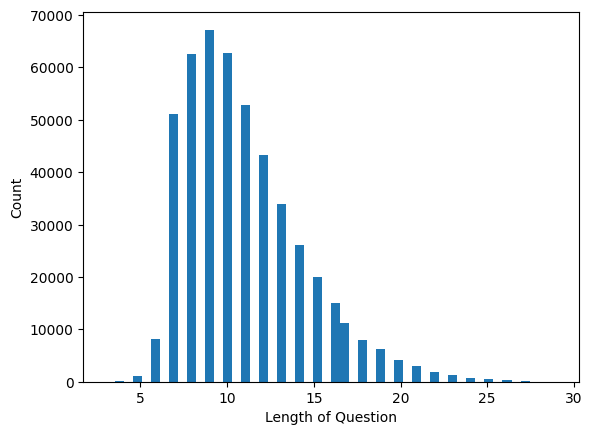

In [14]:
# Plot histogram of length column
plt.hist(df['len_ques'], bins=50)
# Set x and y labels
plt.xlabel('Length of Question')
plt.ylabel('Count')

# Show the plot
plt.show()

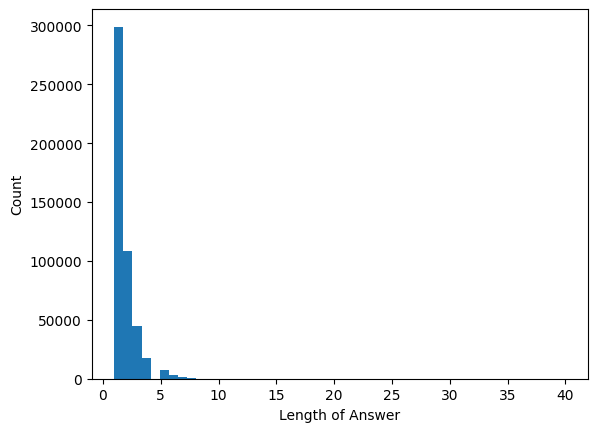

In [15]:
# Plot histogram of length column
plt.hist(df['len_ans'], bins=50)
# Set x and y labels
plt.xlabel('Length of Answer')
plt.ylabel('Count')

# Show the plot
plt.show()

In [16]:
#df = df.iloc[:5000]

# **Tokenization**

In [35]:
MODEL_NAME = 'google/flan-t5-base'

In [36]:
tokenizer = Tokenizer.from_pretrained(MODEL_NAME)

In [37]:
class NQADataset(Dataset):
  def __init__(self,data : pd.DataFrame,tokenizer : Tokenizer,source_max_token_len : int = 400,target_max_token_len : int = 32):

    self.tokenizer = tokenizer
    self.data = data
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index : int):
    data_row = self.data.iloc[index]

    source_encoding = tokenizer(
        data_row['question'],
        data_row['paragraph'],
        max_length = self.source_max_token_len,
        padding = "max_length",
        truncation = "only_second",
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt")
    
    target_encoding = tokenizer(
        data_row['answer'],
        max_length = self.target_max_token_len,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt")
    
    labels = target_encoding["input_ids"]
    labels[labels == 0] = -100

    return dict(
        answer = data_row['answer'],
        input_ids = source_encoding['input_ids'].flatten(),
        attention_mask = source_encoding['attention_mask'].flatten(),
        labels = labels.flatten())

In [38]:
sample_dataset = NQADataset(df,tokenizer)

In [39]:
for data in sample_dataset:
  print(data['answer'])
  print(data['input_ids'][:10])
  print(data['labels'][:10])
  break


Vikram Dalal
tensor([2645,   19,    8, 5037, 2090,   13, 8951,   49,  397,   15])
tensor([ 1813,   157,  2375, 10729,   138,     1,  -100,  -100,  -100,  -100])


In [40]:
train_df, val_df = train_test_split(df,test_size=0.2)
val_df, test_df = train_test_split(val_df,test_size=0.5)

In [41]:
train_df.shape, val_df.shape, test_df.shape

((385406, 8), (48176, 8), (48176, 8))

In [42]:
class NQADataModule(pl.LightningDataModule):
  def __init__(self,train_df , val_df, test_df,tokenizer : Tokenizer,batch_size : int = 8,source_max_token_len : int = 400,target_max_token_len : int = 32):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.val_df = val_df
    self.tokenizer = tokenizer
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def setup(self,stage=None):
    self.train_dataset = NQADataset(self.train_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.val_dataset = NQADataset(self.val_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.test_dataset = NQADataset(self.test_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=2)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size = self.batch_size,num_workers=2)

  def test_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,num_workers=2)   

In [43]:
type(train_df)

pandas.core.frame.DataFrame

In [44]:
BATCH_SIZE = 64
N_EPOCHS = 2

data_module = NQADataModule(train_df,val_df,test_df,tokenizer,batch_size = BATCH_SIZE)
data_module.setup()

In [45]:
def compute_meteor_scores(predictions, answers):
    scores = []
    for pred, ans in zip(predictions, answers):
        pred_tokens = word_tokenize(pred)
        ans_tokens = word_tokenize(ans)
        score = meteor([ans_tokens], pred_tokens, gamma=0)
        scores.append(score)
    return sum(scores) / len(scores)

In [46]:
chencherry = SmoothingFunction()
def compute_bleu_scores(predictions, answers):
    scores = []
    for pred, ans in zip(predictions, answers):
        pred_tokens = word_tokenize(pred)
        ans_tokens = word_tokenize(ans)
        score = sentence_bleu([ans_tokens], pred_tokens,smoothing_function=chencherry.method7)
        scores.append(score)
    return sum(scores) / len(scores)

In [47]:
def compute_rouge_scores(predictions, answers):
    rouge = Rouge()
    scores = []
    for pred, ans in zip(predictions, answers):
        score = rouge.get_scores(pred, ans)[0]['rouge-1']['f']
        scores.append(score)
    return sum(scores) / len(scores)


In [48]:
class NQAModel(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME,return_dict=True)

  def forward(self,input_ids,attention_mask,labels=None):
    output = self.model(
        input_ids = input_ids,
        attention_mask = attention_mask,
        labels = labels)
    
    return output.loss, output.logits

  def training_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids,attention_mask,labels)
    self.log("train_loss",loss,prog_bar=True,logger=True)
    return loss

  def validation_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    answer = batch['answer']
    loss, outputs = self(input_ids,attention_mask,labels)

    # Generate predictions from the model
    predictions = self.model.generate(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      num_beams = 1,
                                      max_length = 32,
                                      repetition_penalty = 2.5,
                                      length_penalty = 1.0,
                                      early_stopping = True,
                                      use_cache = True)
    
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    meteor_score = compute_meteor_scores(predictions, answer)
    blue_score = compute_bleu_scores(predictions, answer)

    self.log_dict({"val_loss" : loss,"val_METEOR" : meteor_score,"val_BLUE" : blue_score},prog_bar=True,logger=True)

    return loss

  def test_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    answer = batch['answer']
    loss, outputs = self(input_ids,attention_mask,labels)

    # Generate predictions from the model
    predictions = self.model.generate(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      num_beams = 1,
                                      max_length = 32,
                                      repetition_penalty = 2.5,
                                      length_penalty = 1.0,
                                      early_stopping = True,
                                      use_cache = True)
    
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    meteor_score = compute_meteor_scores(predictions, answer)
    blue_score = compute_bleu_scores(predictions, answer)

    self.log_dict({"test_loss" : loss,"test_METEOR" : meteor_score,"test_BLUE" : blue_score},prog_bar=True,logger=True)
    return loss

  def configure_optimizers(self):
    return AdamW(self.parameters(),lr = 0.0001)

In [49]:
model = NQAModel()

In [50]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

In [51]:
trainer = pl.Trainer(accelerator="tpu",devices=8,
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: True, using: 8 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [52]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 247 M 
-----------------------------------------------------
247 M     Trainable params
0         Non-trainable params
247 M     Total params
990.311   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

INFO:pytorch_lightning.trainer.connectors.signal_connector:[rank: 1] Received SIGTERM: 15


ProcessExitedException: ignored

# **Load the Model from chechkpoint**

In [ ]:
cppath = '/content/checkpoints/best_cp.ckpt'
trained_model = NQAModel.load_from_checkpoint(cppath)
trained_model.freeze()

In [ ]:
trainer.test(trained_model, data_module)

## **Make Prediction on Sample**

In [ ]:
def generate_ans(question):
    source_encoding = tokenizer(
        question['question'],
        question['paragraph'],
        max_length = 400,
        padding = "max_length",
        truncation = "only_second",
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt")
    
    generated_ids = trained_model.model.generate(
        input_ids = source_encoding['input_ids'],
        attention_mask = source_encoding['attention_mask'],
        num_beams = 1,
        max_length = 32,
        repetition_penalty = 2.5,
        length_penalty = 1.0,
        early_stopping = True,
        use_cache = True)
    
    return tokenizer.decode(generated_ids[0],skip_special_tokens=True,clean_up_tokenization_spaces=True)
    

In [ ]:
sample_question = test_df.iloc[1]

In [ ]:
sample_question['question']

In [ ]:
sample_question['answer']

In [ ]:
generate_ans(sample_question)

In [ ]:
data = {'question': ['What is the amount spent on Helicopter for VVIP?'],
        'paragraph' : ['The federal government in its written response informed the Senate that according to the details provided by the Cabinet Division, an amount of ₹ 946.3 million was spent on VVIP helicopter missions by 6 Aviation Squadron under instructions of the PMs Office from 2019 to 2021 when Imran Khan was the prime minister of the country.']
       }

d = pd.DataFrame(data)

In [ ]:
generate_ans(d.iloc[0])